In [1]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


2025-07-16 10:34:08.077098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752662048.269892      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752662048.328795      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
Num GPUs Available: 1


In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 28.4 MB/s eta 0:00:0000:0100:01


In [3]:

import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics, callbacks
from tensorflow.keras.optimizers import Adam
import rasterio
from rasterio.enums import Resampling
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [4]:
data_path = "/kaggle/input/satalite-dataset/data"
images_path = os.path.join(data_path, "images")
labels_path = os.path.join(data_path, "labels")
image_extensions = ('.png', '.jpg', '.jpeg', '.tif', '.tiff')

image_files = [f for f in os.listdir(images_path) if f.lower().endswith(image_extensions)]

label_files = [
    f for f in os.listdir(labels_path)
    if f.lower().endswith(image_extensions) and '_' not in os.path.splitext(f)[0]
]


print(f"Number of images: {len(image_files)}")
print(f"Number of labels: {len(label_files)}")


Number of images: 306
Number of labels: 306


In [5]:
def display_image_and_mask(img_path, mask_path):
    # Check file extension to decide how to open
    if img_path.lower().endswith(('.tif', '.tiff')):
        try:
            with rasterio.open(img_path) as src:
                # Read the first 3 bands for display as RGB (if available)
                # Or read a single band if less than 3 bands
                num_bands = src.count
                if num_bands >= 3:
                    img = src.read([src.indexes[0], src.indexes[1], src.indexes[2]])
                    img = np.transpose(img, (1, 2, 0)) # Transpose to (height, width, bands)
                else:
                    img = src.read(1)
                    img = np.squeeze(img) # Remove single-dimensional entries
                # Normalize image data for display if it's not already in 0-255 range
                if img.max() > 255 or img.min() < 0:
                     img = (img - img.min()) / (img.max() - img.min()) * 255
                     img = img.astype(np.uint8)

        except Exception as e:
            print(f"Error reading image file {img_path} with rasterio: {e}")
            return
    else:
        try:
            img = Image.open(img_path)
        except Exception as e:
            print(f"Error reading image file {img_path} with PIL: {e}")
            return

    try:
        # Assuming masks are single band images and can be opened by PIL
        mask = Image.open(mask_path)
    except Exception as e:
        print(f"Error reading mask file {mask_path} with PIL: {e}")
        return


    # Plot the image and the mask side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    plt.show()

✅ Displaying first 5 image-mask pairs from 306 available...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


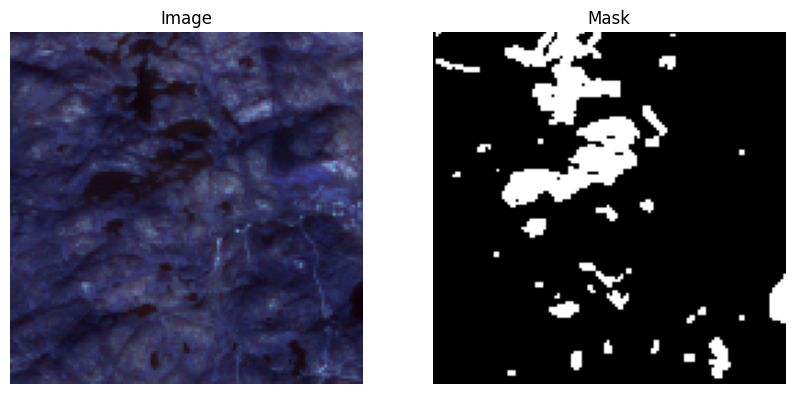

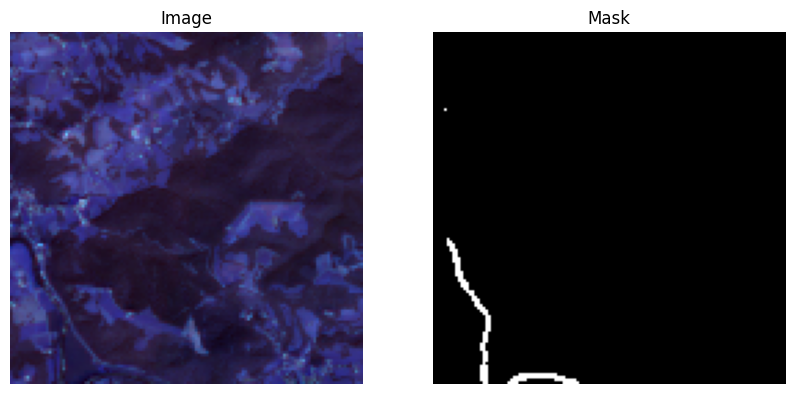

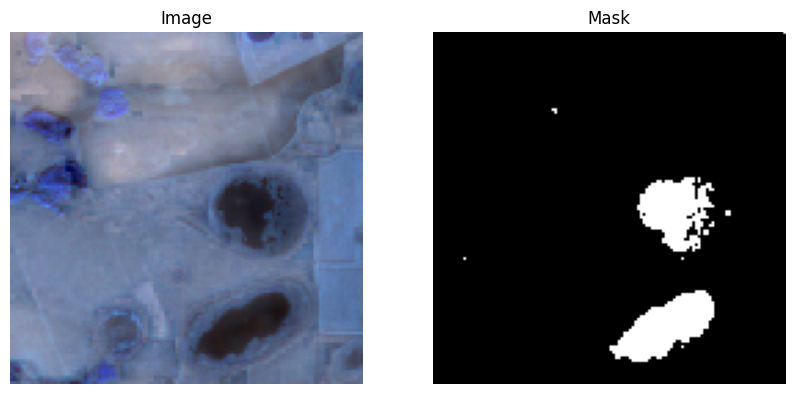

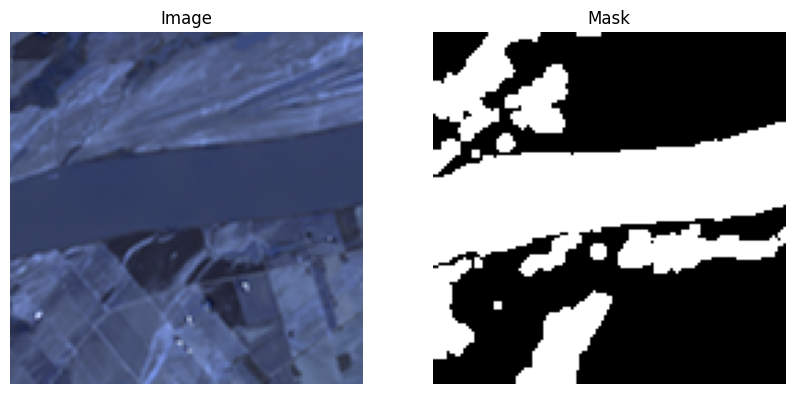

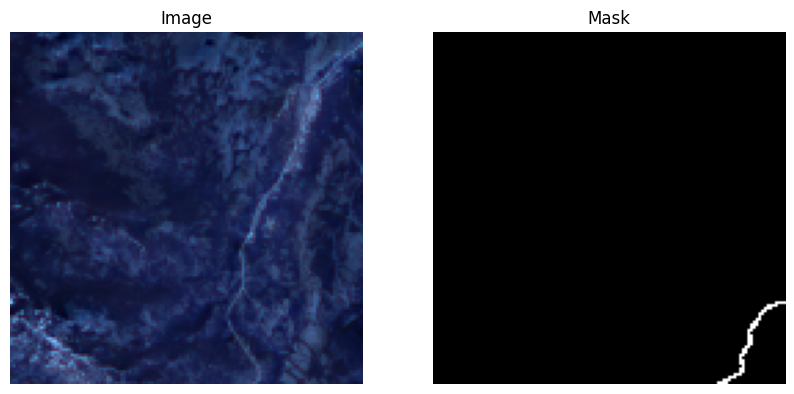

In [6]:
data_path = "/kaggle/input/satalite-dataset/data"
train_img_dir = os.path.join(data_path, "images")
train_mask_dir = os.path.join(data_path, "labels")

# Filter valid image/mask files
image_extensions = ('.png', '.jpg', '.jpeg', '.tif', '.tiff')

train_img_files = sorted([f for f in os.listdir(train_img_dir) if f.lower().endswith(image_extensions)])
train_mask_files = sorted([f for f in os.listdir(train_mask_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg')) and '_' not in f]) # Filter masks for common image types


# Confirm alignment - assuming image and mask filenames are the same except for extension
# This is a simplified check, a more robust approach would match base filenames
img_basenames = [os.path.splitext(f)[0] for f in train_img_files]
mask_basenames = [os.path.splitext(f)[0] for f in train_mask_files]

# Find common basenames
common_basenames = sorted(list(set(img_basenames) & set(mask_basenames)))

if len(common_basenames) == 0:
    print("❌ Error: No matching image and mask files found.")
else:
    print(f"✅ Displaying first 5 image-mask pairs from {len(common_basenames)} available...")
    for basename in common_basenames[:5]:
        # Find the full path for the image and mask using the basename
        img_file = next((f for f in train_img_files if os.path.splitext(f)[0] == basename), None)
        mask_file = next((f for f in train_mask_files if os.path.splitext(f)[0] == basename), None)

        if img_file and mask_file:
            img_path = os.path.join(train_img_dir, img_file)
            mask_path = os.path.join(train_mask_dir, mask_file)
            display_image_and_mask(img_path, mask_path)
        else:
            print(f"Warning: Could not find matching image or mask for basename {basename}")

In [7]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

def extract_number(fname):
    return int(os.path.splitext(fname)[0])

image_files = [f for f in os.listdir(images_path) if f.endswith('.tif')]
label_files = [f for f in os.listdir(labels_path) if f.endswith('.png') and '_' not in f]

image_dict = {extract_number(f): os.path.join(images_path, f) for f in image_files}
label_dict = {extract_number(f): os.path.join(labels_path, f) for f in label_files}

common_keys = sorted(set(image_dict.keys()) & set(label_dict.keys()))

print(f"Found {len(common_keys)} matching image-label pairs.")

X, Y = [], []

for k in common_keys:
    img_path = image_dict[k]
    label_path = label_dict[k]

    try:
        with rasterio.open(img_path) as src:
            img = src.read(out_shape=(src.count, IMG_HEIGHT, IMG_WIDTH), resampling=rasterio.enums.Resampling.nearest)
            img = img.astype(np.float32)
            for b in range(img.shape[0]):
                band = img[b]
                # img[b] = (band - band.min()) / (band.max() - band.min() + 1e-8) # normalize
            img = np.transpose(img, (1, 2, 0))


        with rasterio.open(label_path) as lbl_src:
            label = lbl_src.read(1)
            label = cv2.resize(label, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
            label = (label > 0).astype(np.uint8)

        X.append(img)
        Y.append(label)

    except Exception as e:
        print(f"Error loading {img_path} or {label_path}: {e}")


X = np.array(X)
Y = np.expand_dims(np.array(Y), axis=-1)

print("X shape:", X.shape)
print("Y shape:", Y.shape)


Found 306 matching image-label pairs.
X shape: (306, 128, 128, 12)
Y shape: (306, 128, 128, 1)


In [8]:
import numpy as np

has_water = [(y > 0).any() for y in Y]

num_with_water = sum(has_water)
num_without_water = len(Y) - num_with_water

print(f"✅ Images with water:     {num_with_water}")
print(f"❌ Images without water:  {num_without_water}")


✅ Images with water:     261
❌ Images without water:  45


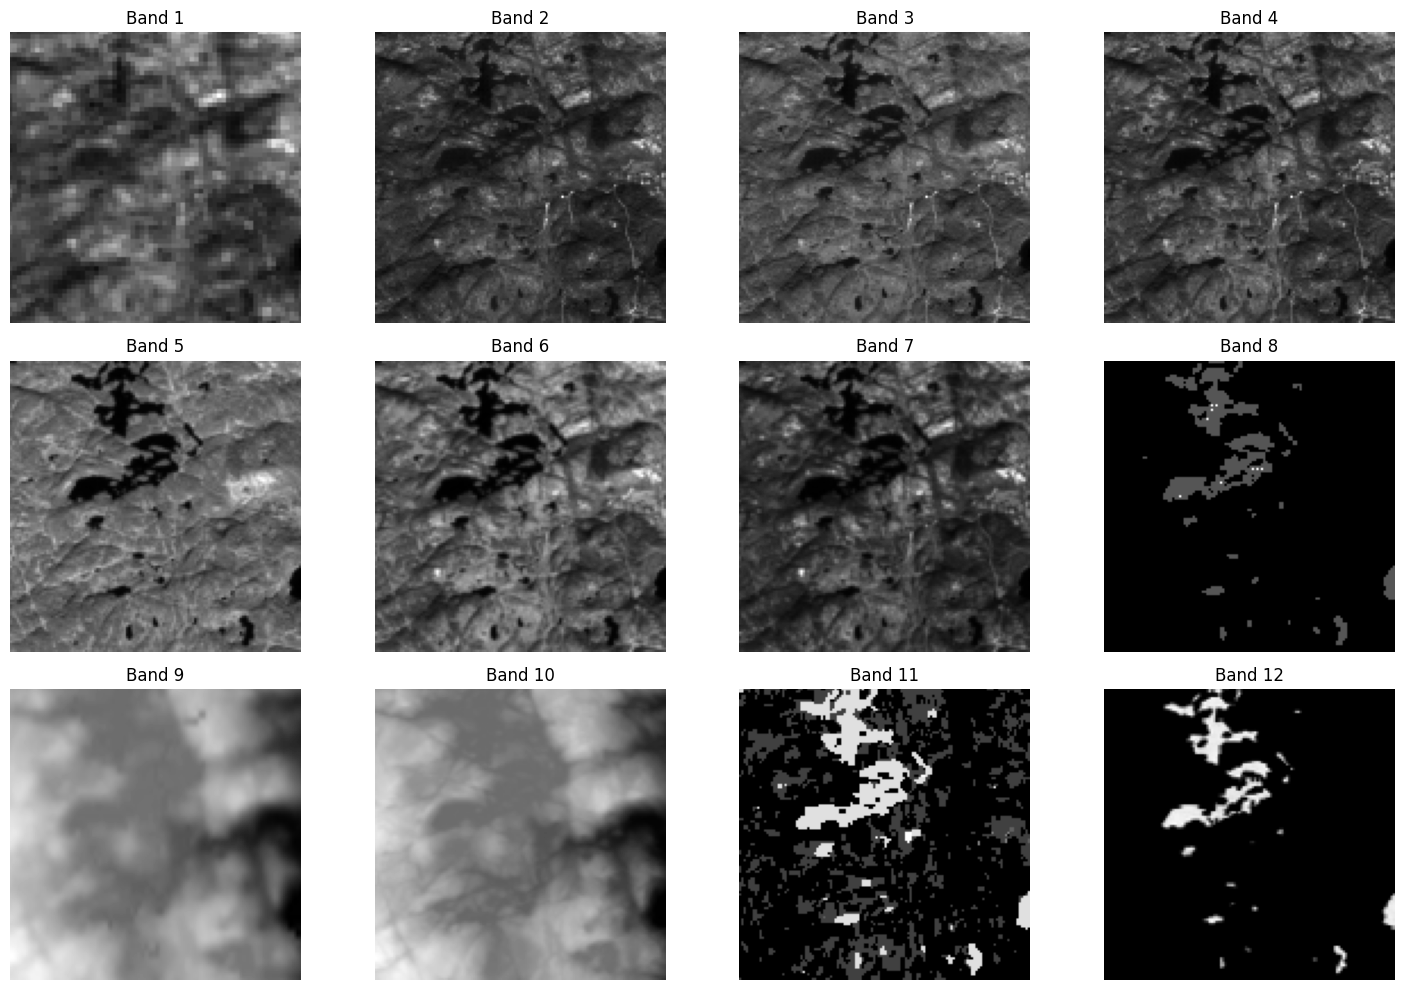

In [9]:

first_image = X[0]
num_bands = first_image.shape[-1]

plt.figure(figsize=(15, 10))

for i in range(num_bands):
    plt.subplot(3, 4, i + 1)
    plt.imshow(first_image[:, :, i], cmap='gray')
    plt.title(f"Band {i + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [10]:
print("Before normalization:")
for i in range(num_bands):
    band = X[:, :, :, i]
    print(f"Band {i+1}: min={band.min():.3f}, max={band.max():.3f}, mean={band.mean():.3f}")

band_mins = np.min(X, axis=(0, 1, 2))
band_maxs = np.max(X, axis=(0, 1, 2))
X_normalized = (X - band_mins) / (band_maxs - band_mins + 1e-8)

print("\nAfter normalization:")
for i in range(num_bands):
    band = X_normalized[:, :, :, i]
    print(f"Band {i+1}: min={band.min():.3f}, max={band.max():.3f}, mean={band.mean():.3f}")


Before normalization:
Band 1: min=-1393.000, max=6568.000, mean=396.468
Band 2: min=-1169.000, max=9659.000, mean=494.621
Band 3: min=-722.000, max=11368.000, mean=822.320
Band 4: min=-684.000, max=12041.000, mean=973.675
Band 5: min=-412.000, max=15841.000, mean=2090.111
Band 6: min=-335.000, max=15252.000, mean=1964.051
Band 7: min=-258.000, max=14647.000, mean=1351.274
Band 8: min=64.000, max=255.000, mean=102.740
Band 9: min=-9999.000, max=4245.000, mean=141.804
Band 10: min=8.000, max=4287.000, mean=300.741
Band 11: min=10.000, max=100.000, mean=35.103
Band 12: min=0.000, max=111.000, mean=9.753

After normalization:
Band 1: min=0.000, max=1.000, mean=0.225
Band 2: min=0.000, max=1.000, mean=0.154
Band 3: min=0.000, max=1.000, mean=0.128
Band 4: min=0.000, max=1.000, mean=0.130
Band 5: min=0.000, max=1.000, mean=0.154
Band 6: min=0.000, max=1.000, mean=0.147
Band 7: min=0.000, max=1.000, mean=0.108
Band 8: min=0.000, max=1.000, mean=0.203
Band 9: min=0.000, max=1.000, mean=0.712
B

In [11]:
# # Band indices (0-based): Blue=1, Green=2, Red=3, NIR=7, Water Vapor=8, SWIR-1=10, SWIR-2=11

# selected_band_indices = [1, 2, 3, 7, 8, 10, 11]

# Recommended bands: Blue, Green, Red, NIR, SWIR1, SWIR2, Water Occurrence Probability
selected_band_indices = [1, 2, 3, 4, 5, 6, 11]

X_selected = X[:, :, :, selected_band_indices]

print("Original X shape:", X.shape)
print("Filtered X shape:", X_selected.shape)

Original X shape: (306, 128, 128, 12)
Filtered X shape: (306, 128, 128, 7)


In [12]:
# First split: Train + Val and Test
X_temp, X_test, Y_temp, Y_test = train_test_split(
    X_selected, Y, test_size=0.2, random_state=SEED, stratify=None
)

# Second split: Train and Validation
X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp, test_size=0.2, random_state=SEED, stratify=None
)

# Print shapes
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (195, 128, 128, 7)
Y_train shape: (195, 128, 128, 1)
X_val shape: (49, 128, 128, 7)
Y_val shape: (49, 128, 128, 1)
X_test shape: (62, 128, 128, 7)
Y_test shape: (62, 128, 128, 1)


In [13]:
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42


def augment(image, mask):
    # Horizontal flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Vertical flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    # Random 90-degree rotation
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    mask = tf.image.rot90(mask, k)

    return image, mask


def process_sample(image, mask, training):
    if training:
        image, mask = augment(image, mask)
    return image, mask


def prepare_dataset(X, Y, training=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))

    if training:
        dataset = dataset.shuffle(buffer_size=len(X), seed=SEED, reshuffle_each_iteration=True)

    dataset = dataset.map(lambda img, mask: process_sample(img, mask, training),
                          num_parallel_calls=AUTOTUNE)

    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)

    return dataset

In [14]:
train_dataset = prepare_dataset(X_train, Y_train, training=True)
val_dataset   = prepare_dataset(X_val, Y_val, training=False)
test_dataset  = prepare_dataset(X_test, Y_test, training=False)

I0000 00:00:1752662083.261789      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [15]:
# INPUT_SHAPE = (128, 128, len(selected_band_indices))

# def conv_block(x, filters):
#     x = layers.Conv2D(filters, 3, padding='same',
#                       kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)
#     x = layers.Conv2D(filters, 3, padding='same',
#                       kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)
#     return x


# def encoder_block(x, filters):
#     f = conv_block(x, filters)
#     p = layers.MaxPooling2D()(f)
#     return f, p

# def decoder_block(x, skip, filters):
#     x = layers.Conv2DTranspose(filters, 2, strides=2, padding='same',
#                                kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
#     x = layers.Concatenate()([x, skip])
#     x = conv_block(x, filters)
#     return x


# def unet_base(input_shape):
#     inputs = layers.Input(input_shape)

#     s1, p1 = encoder_block(inputs, 64)
#     s2, p2 = encoder_block(p1, 128)
#     s3, p3 = encoder_block(p2, 256)

#     b = conv_block(p3, 512)

#     d1 = decoder_block(b, s3, 256)
#     d2 = decoder_block(d1, s2, 128)
#     d3 = decoder_block(d2, s1, 64)

#     outputs = layers.Conv2D(1, 1, activation='sigmoid')(d3)

#     return models.Model(inputs, outputs)

# def resunet(input_shape):
#     inputs = layers.Input(input_shape)

#     s1, p1 = encoder_block(inputs, 32)
#     s2, p2 = encoder_block(p1, 64)
#     s3, p3 = encoder_block(p2, 128)

#     b = conv_block(p3, 256)

#     d1 = decoder_block(b, s3, 128)
#     d2 = decoder_block(d1, s2, 64)
#     d3 = decoder_block(d2, s1, 32)

#     outputs = layers.Conv2D(1, 1, activation='sigmoid')(d3)

#     return models.Model(inputs, outputs)


# def dilated_resunet(input_shape):
#     inputs = layers.Input(input_shape)

#     s1, p1 = encoder_block(inputs, 64)
#     p1 = layers.Dropout(0.2)(p1)

#     s2, p2 = encoder_block(p1, 128)
#     p2 = layers.Dropout(0.3)(p2)

#     s3, p3 = encoder_block(p2, 256)
#     p3 = layers.Dropout(0.4)(p3)

#     b = conv_block(p3, 512)

#     d1 = decoder_block(b, s3, 256)
#     d2 = decoder_block(d1, s2, 128)
#     d3 = decoder_block(d2, s1, 64)

#     outputs = layers.Conv2D(1, 1, activation='sigmoid')(d3)

#     return models.Model(inputs, outputs)

# def aer_unet(input_shape):
#     inputs = layers.Input(input_shape)

#     s1, p1 = encoder_block(inputs, 64)
#     s2, p2 = encoder_block(p1, 128)
#     s3, p3 = encoder_block(p2, 256)
#     s4, p4 = encoder_block(p3, 512)

#     b = conv_block(p4, 1024)

#     d1 = decoder_block(b, s4, 512)
#     d2 = decoder_block(d1, s3, 256)
#     d3 = decoder_block(d2, s2, 128)
#     d4 = decoder_block(d3, s1, 64)

#     outputs = layers.Conv2D(1, 1, activation='sigmoid')(d4)

#     return models.Model(inputs, outputs)



In [16]:
INPUT_SHAPE = (128, 128, len(selected_band_indices))


def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def unet_base(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D()(c4)

    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)

    return models.Model(inputs, outputs)



def residual_block(x, filters, dilation=1):
    skip = x

    # Project skip connection to match x's shape if necessary
    if skip.shape[-1] != filters:
        skip = layers.Conv2D(filters, 1, padding='same')(skip)

    x = layers.Conv2D(filters, 3, padding='same', dilation_rate=dilation)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, padding='same', dilation_rate=dilation)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([x, skip])  # Now skip has same shape as x
    x = layers.ReLU()(x)

    return x


def resunet(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder
    x1 = residual_block(inputs, 64)
    p1 = layers.MaxPooling2D()(x1)

    x2 = residual_block(p1, 128)
    p2 = layers.MaxPooling2D()(x2)

    x3 = residual_block(p2, 256)
    p3 = layers.MaxPooling2D()(x3)

    x4 = residual_block(p3, 512)
    p4 = layers.MaxPooling2D()(x4)

    x5 = residual_block(p4, 1024)

    # Decoder
    u6 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(x5)
    u6 = layers.concatenate([u6, x4])
    x6 = residual_block(u6, 512)

    u7 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(x6)
    u7 = layers.concatenate([u7, x3])
    x7 = residual_block(u7, 256)

    u8 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(x7)
    u8 = layers.concatenate([u8, x2])
    x8 = residual_block(u8, 128)

    u9 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(x8)
    u9 = layers.concatenate([u9, x1])
    x9 = residual_block(u9, 64)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x9)

    return models.Model(inputs, outputs)


def dilated_resunet(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder with dilated convolutions
    x1 = residual_block(inputs, 64, dilation=1)
    p1 = layers.MaxPooling2D()(x1)

    x2 = residual_block(p1, 128, dilation=2)
    p2 = layers.MaxPooling2D()(x2)

    x3 = residual_block(p2, 256, dilation=4)
    p3 = layers.MaxPooling2D()(x3)

    x4 = residual_block(p3, 512, dilation=8)

    # Decoder
    u3 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(x4)
    u3 = layers.concatenate([u3, x3])
    d3 = residual_block(u3, 256)

    u2 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(d3)
    u2 = layers.concatenate([u2, x2])
    d2 = residual_block(u2, 128)

    u1 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(d2)
    u1 = layers.concatenate([u1, x1])
    d1 = residual_block(u1, 64)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d1)

    return models.Model(inputs, outputs)

def attention_gate(x, g, filters):
    theta_x = layers.Conv2D(filters, 1, padding='same')(x)
    phi_g = layers.Conv2D(filters, 1, padding='same')(g)
    add = layers.Add()([theta_x, phi_g])
    act = layers.ReLU()(add)
    psi = layers.Conv2D(1, 1)(act)
    psi = layers.Activation('sigmoid')(psi)
    return layers.Multiply()([x, psi])


def aer_unet(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder
    x1 = conv_block(inputs, 64); p1 = layers.MaxPooling2D()(x1)
    x2 = conv_block(p1, 128); p2 = layers.MaxPooling2D()(x2)
    x3 = conv_block(p2, 256); p3 = layers.MaxPooling2D()(x3)
    x4 = conv_block(p3, 512); p4 = layers.MaxPooling2D()(x4)
    x5 = conv_block(p4, 1024)

    # Decoder with attention
    u4 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(x5)
    att4 = attention_gate(x4, u4, 256)
    m4 = layers.Concatenate()([u4, att4])
    x6 = conv_block(m4, 512)

    u3 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(x6)
    att3 = attention_gate(x3, u3, 128)
    m3 = layers.Concatenate()([u3, att3])
    x7 = conv_block(m3, 256)

    u2 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(x7)
    att2 = attention_gate(x2, u2, 64)
    m2 = layers.Concatenate()([u2, att2])
    x8 = conv_block(m2, 128)

    u1 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(x8)
    att1 = attention_gate(x1, u1, 32)
    m1 = layers.Concatenate()([u1, att1])
    x9 = conv_block(m1, 64)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x9)
    return models.Model(inputs, outputs)


In [17]:
model_variants = {
    "UNet_Base": unet_base,
    "Resunet": resunet,
    "Dilated_resunet": dilated_resunet,
    "Aer_unet": aer_unet
}


In [18]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)


In [19]:
# learning_rates = [1e-4, 5e-4, 1e-3]
learning_rates = [1e-4, 5e-5, 1e-5]
epochs = 30

In [20]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


In [21]:
def weighted_bce(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)


    total_pixels = np.prod(Y.shape[:-1])
    water_pixels = np.sum(Y)
    background_pixels = total_pixels - water_pixels

    weight_for_0 = total_pixels / (2 * background_pixels)
    weight_for_1 = total_pixels / (2 * water_pixels)


    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
    weight_map = weight_for_0 * (1 - y_true) + weight_for_1 * y_true
    return tf.reduce_mean(bce * weight_map)


In [22]:
# from tensorflow.keras.losses import binary_crossentropy

def combo_loss(y_true, y_pred):
    return weighted_bce(y_true, y_pred) + dice_loss(y_true, y_pred)



In [23]:
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-6)


In [24]:
import tensorflow as tf
from keras import backend as K

def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)
    y_true = tf.cast(y_true, tf.float32)

    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)

    return 2 * (precision * recall) / (precision + recall + 1e-8)


In [25]:
import numpy as np
print("Max values in first 5 masks:", [Y[i].max() for i in range(5)])


Max values in first 5 masks: [1, 1, 1, 1, 1]


In [26]:
results = []

## UNet_Base model

In [27]:
model_1_unet_base = unet_base(INPUT_SHAPE)
model_1_unet_base.compile(
    optimizer=Adam(learning_rate=learning_rates[0]),
    loss=combo_loss,
    metrics=['accuracy',iou_metric,f1_score]
)
history_unet_base_1 = model_1_unet_base.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=2
)

final_metrics = {
            "Model": "UNet_Base",
            "LR": learning_rates[0],
            "Val_Accuracy": history_unet_base_1.history['val_accuracy'][-1],
            "iou_metric" : history_unet_base_1.history['val_iou_metric'][-1],
            "Val_F1": history_unet_base_1.history['val_f1_score'][-1]
}

results.append(final_metrics)
print(f"UNet_Base @ {learning_rates[0]:.0e} → Acc: {final_metrics['Val_Accuracy']:.4f} | F1: {final_metrics['Val_F1']:.4f}")



Epoch 1/30


I0000 00:00:1752662406.773340     106 service.cc:148] XLA service 0x7fa2d4002930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752662406.774075     106 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752662407.706549     106 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752662422.350288     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
E0000 00:00:1752662425.956247     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752662426.189810     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


13/13 - 41s - 3s/step - accuracy: 0.3846 - f1_score: 0.4546 - iou_metric: 0.3058 - loss: 7.1833 - val_accuracy: 0.8446 - val_f1_score: 0.5370 - val_iou_metric: 0.4204 - val_loss: 3.8894
Epoch 2/30
13/13 - 2s - 132ms/step - accuracy: 0.8877 - f1_score: 0.6676 - iou_metric: 0.5246 - loss: 3.1165 - val_accuracy: 0.8353 - val_f1_score: 0.6686 - val_iou_metric: 0.5219 - val_loss: 3.1791
Epoch 3/30
13/13 - 2s - 123ms/step - accuracy: 0.8979 - f1_score: 0.7520 - iou_metric: 0.6061 - loss: 2.6154 - val_accuracy: 0.8405 - val_f1_score: 0.6897 - val_iou_metric: 0.5427 - val_loss: 3.2049
Epoch 4/30
13/13 - 2s - 124ms/step - accuracy: 0.8858 - f1_score: 0.7529 - iou_metric: 0.6164 - loss: 2.4827 - val_accuracy: 0.8471 - val_f1_score: 0.6555 - val_iou_metric: 0.5141 - val_loss: 3.2559
Epoch 5/30
13/13 - 2s - 124ms/step - accuracy: 0.8923 - f1_score: 0.7644 - iou_metric: 0.6224 - loss: 2.4501 - val_accuracy: 0.8482 - val_f1_score: 0.6426 - val_iou_metric: 0.5046 - val_loss: 3.2491
Epoch 6/30
13/13 -

In [28]:
model_2_unet_base = unet_base(INPUT_SHAPE)
model_2_unet_base.compile(
    optimizer=Adam(learning_rate=learning_rates[1]),
    loss=combo_loss,
    metrics=['accuracy', iou_metric, f1_score]
)

history_unet_base_2 = model_2_unet_base.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=2
)

final_metrics = {
    "Model": "UNet_Base",
    "LR": learning_rates[1],
    "Val_Accuracy": history_unet_base_2.history['val_accuracy'][-1],
    "iou_metric": history_unet_base_2.history['val_iou_metric'][-1],
    "f1_score": history_unet_base_2.history['val_f1_score'][-1]
}

results.append(final_metrics)

print(f"UNet_Base @ {learning_rates[1]:.0e} → "
      f"Acc: {final_metrics['Val_Accuracy']:.4f} | "
      f"IoU: {final_metrics['iou_metric']:.4f} | "
      f"F1: {final_metrics['f1_score']:.4f}")


Epoch 1/30
13/13 - 21s - 2s/step - accuracy: 0.2415 - f1_score: 0.3783 - iou_metric: 0.2364 - loss: 8.4382 - val_accuracy: 0.3124 - val_f1_score: 0.3755 - val_iou_metric: 0.2440 - val_loss: 7.6192
Epoch 2/30
13/13 - 2s - 132ms/step - accuracy: 0.6070 - f1_score: 0.5073 - iou_metric: 0.3495 - loss: 5.2422 - val_accuracy: 0.8372 - val_f1_score: 0.5167 - val_iou_metric: 0.3994 - val_loss: 4.1236
Epoch 3/30
13/13 - 2s - 131ms/step - accuracy: 0.8716 - f1_score: 0.6826 - iou_metric: 0.5270 - loss: 3.1958 - val_accuracy: 0.8202 - val_f1_score: 0.6025 - val_iou_metric: 0.4639 - val_loss: 3.3038
Epoch 4/30
13/13 - 2s - 132ms/step - accuracy: 0.8776 - f1_score: 0.6944 - iou_metric: 0.5429 - loss: 2.6260 - val_accuracy: 0.8278 - val_f1_score: 0.6130 - val_iou_metric: 0.4753 - val_loss: 3.2110
Epoch 5/30
13/13 - 2s - 123ms/step - accuracy: 0.8738 - f1_score: 0.7158 - iou_metric: 0.5646 - loss: 2.5777 - val_accuracy: 0.8452 - val_f1_score: 0.5898 - val_iou_metric: 0.4649 - val_loss: 3.3718
Epoch 6

In [29]:
model_3_unet_base = unet_base(INPUT_SHAPE)
model_3_unet_base.compile(
    optimizer=Adam(learning_rate=learning_rates[2]),
    loss=combo_loss,
    metrics=['accuracy', iou_metric, f1_score]
)

history_unet_base_3 = model_3_unet_base.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=2
)

final_metrics = {
    "Model": "UNet_Base",
    "LR": learning_rates[2],
    "Val_Accuracy": history_unet_base_3.history['val_accuracy'][-1],
    "iou_metric": history_unet_base_3.history['val_iou_metric'][-1],
    "f1_score": history_unet_base_3.history['val_f1_score'][-1]
}

results.append(final_metrics)

print(f"UNet_Base @ {learning_rates[2]:.0e} → "
      f"Acc: {final_metrics['Val_Accuracy']:.4f} | "
      f"IoU: {final_metrics['iou_metric']:.4f} | "
      f"F1: {final_metrics['f1_score']:.4f}")


Epoch 1/30
13/13 - 21s - 2s/step - accuracy: 0.2692 - f1_score: 0.3755 - iou_metric: 0.2344 - loss: 8.0129 - val_accuracy: 0.4613 - val_f1_score: 0.4000 - val_iou_metric: 0.2666 - val_loss: 5.8988
Epoch 2/30
13/13 - 2s - 130ms/step - accuracy: 0.6942 - f1_score: 0.5611 - iou_metric: 0.3976 - loss: 4.1389 - val_accuracy: 0.8203 - val_f1_score: 0.6050 - val_iou_metric: 0.4535 - val_loss: 3.8345
Epoch 3/30
13/13 - 2s - 130ms/step - accuracy: 0.8743 - f1_score: 0.6815 - iou_metric: 0.5209 - loss: 3.1644 - val_accuracy: 0.8418 - val_f1_score: 0.6131 - val_iou_metric: 0.4672 - val_loss: 3.7603
Epoch 4/30
13/13 - 2s - 131ms/step - accuracy: 0.8865 - f1_score: 0.7021 - iou_metric: 0.5590 - loss: 2.9707 - val_accuracy: 0.8384 - val_f1_score: 0.6306 - val_iou_metric: 0.4835 - val_loss: 3.5727
Epoch 5/30
13/13 - 2s - 131ms/step - accuracy: 0.8813 - f1_score: 0.6995 - iou_metric: 0.5469 - loss: 2.7745 - val_accuracy: 0.8276 - val_f1_score: 0.6420 - val_iou_metric: 0.4924 - val_loss: 3.4338
Epoch 6

## Resunet

In [30]:
model_1_Resunet = resunet(INPUT_SHAPE)
model_1_Resunet.compile(
    optimizer=Adam(learning_rate=learning_rates[0]),
    loss=combo_loss,
    metrics=['accuracy', iou_metric, f1_score]
)

history_Resunet_1 = model_1_Resunet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=2
)

final_metrics = {
    "Model": "Resunet",
    "LR": learning_rates[0],
    "Val_Accuracy": history_Resunet_1.history['val_accuracy'][-1],
    "iou_metric": history_Resunet_1.history['val_iou_metric'][-1],
    "f1_score": history_Resunet_1.history['val_f1_score'][-1]
}

results.append(final_metrics)

print(f"Resunet @ {learning_rates[0]:.0e} → "
      f"Acc: {final_metrics['Val_Accuracy']:.4f} | "
      f"IoU: {final_metrics['iou_metric']:.4f} | "
      f"F1: {final_metrics['f1_score']:.4f}")


Epoch 1/30
13/13 - 50s - 4s/step - accuracy: 0.7560 - f1_score: 0.4871 - iou_metric: 0.3359 - loss: 5.1749 - val_accuracy: 0.8474 - val_f1_score: 0.5119 - val_iou_metric: 0.3915 - val_loss: 4.3170
Epoch 2/30
13/13 - 2s - 156ms/step - accuracy: 0.8648 - f1_score: 0.6606 - iou_metric: 0.4999 - loss: 3.5440 - val_accuracy: 0.8414 - val_f1_score: 0.5523 - val_iou_metric: 0.4242 - val_loss: 3.8727
Epoch 3/30
13/13 - 2s - 155ms/step - accuracy: 0.8770 - f1_score: 0.7077 - iou_metric: 0.5512 - loss: 2.9884 - val_accuracy: 0.8324 - val_f1_score: 0.5957 - val_iou_metric: 0.4565 - val_loss: 3.6156
Epoch 4/30
13/13 - 2s - 155ms/step - accuracy: 0.8845 - f1_score: 0.7333 - iou_metric: 0.5856 - loss: 2.7703 - val_accuracy: 0.8359 - val_f1_score: 0.6010 - val_iou_metric: 0.4634 - val_loss: 3.5184
Epoch 5/30
13/13 - 2s - 155ms/step - accuracy: 0.8897 - f1_score: 0.7259 - iou_metric: 0.5777 - loss: 2.7240 - val_accuracy: 0.8201 - val_f1_score: 0.6035 - val_iou_metric: 0.4588 - val_loss: 3.4932
Epoch 6

In [31]:
model_2_Resunet = resunet(INPUT_SHAPE)
model_2_Resunet.compile(
    optimizer=Adam(learning_rate=learning_rates[1]),
    loss=combo_loss,
    metrics=['accuracy', iou_metric, f1_score]
)

history_Resunet_2 = model_2_Resunet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=2
)

final_metrics = {
    "Model": "Resunet",
    "LR": learning_rates[1],
    "Val_Accuracy": history_Resunet_2.history['val_accuracy'][-1],
    "iou_metric": history_Resunet_2.history['val_iou_metric'][-1],
    "f1_score": history_Resunet_2.history['val_f1_score'][-1]
}

results.append(final_metrics)

print(f"Resunet @ {learning_rates[1]:.0e} → "
      f"Acc: {final_metrics['Val_Accuracy']:.4f} | "
      f"IoU: {final_metrics['iou_metric']:.4f} | "
      f"F1: {final_metrics['f1_score']:.4f}")


Epoch 1/30
13/13 - 45s - 3s/step - accuracy: 0.5890 - f1_score: 0.0598 - iou_metric: 0.0313 - loss: 9.1442 - val_accuracy: 0.6417 - val_f1_score: 0.0164 - val_iou_metric: 0.0083 - val_loss: 10.4255
Epoch 2/30
13/13 - 2s - 157ms/step - accuracy: 0.7508 - f1_score: 0.0349 - iou_metric: 0.0184 - loss: 7.9622 - val_accuracy: 0.6974 - val_f1_score: 0.0049 - val_iou_metric: 0.0025 - val_loss: 9.9306
Epoch 3/30
13/13 - 2s - 155ms/step - accuracy: 0.7660 - f1_score: 0.0375 - iou_metric: 0.0198 - loss: 7.8333 - val_accuracy: 0.6989 - val_f1_score: 0.0101 - val_iou_metric: 0.0051 - val_loss: 9.8995
Epoch 4/30
13/13 - 2s - 155ms/step - accuracy: 0.7676 - f1_score: 0.0690 - iou_metric: 0.0368 - loss: 7.7346 - val_accuracy: 0.6998 - val_f1_score: 0.0382 - val_iou_metric: 0.0196 - val_loss: 9.7799
Epoch 5/30
13/13 - 2s - 155ms/step - accuracy: 0.7612 - f1_score: 0.1590 - iou_metric: 0.0890 - loss: 7.2279 - val_accuracy: 0.6835 - val_f1_score: 0.2325 - val_iou_metric: 0.1338 - val_loss: 8.4159
Epoch 

In [32]:
model_3_Resunet = resunet(INPUT_SHAPE)
model_3_Resunet.compile(
    optimizer=Adam(learning_rate=learning_rates[2]),
    loss=combo_loss,
    metrics=['accuracy', iou_metric, f1_score]
)

history_Resunet_3 = model_3_Resunet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=2
)

final_metrics = {
    "Model": "Resunet",
    "LR": learning_rates[2],
    "Val_Accuracy": history_Resunet_3.history['val_accuracy'][-1],
    "iou_metric": history_Resunet_3.history['val_iou_metric'][-1],
    "f1_score": history_Resunet_3.history['val_f1_score'][-1]
}

results.append(final_metrics)

print(f"Resunet @ {learning_rates[2]:.0e} → "
      f"Acc: {final_metrics['Val_Accuracy']:.4f} | "
      f"IoU: {final_metrics['iou_metric']:.4f} | "
      f"F1: {final_metrics['f1_score']:.4f}")


Epoch 1/30
13/13 - 45s - 3s/step - accuracy: 0.7637 - f1_score: 0.0219 - iou_metric: 0.0112 - loss: 7.8874 - val_accuracy: 0.6952 - val_f1_score: 0.0229 - val_iou_metric: 0.0119 - val_loss: 9.9636
Epoch 2/30
13/13 - 2s - 155ms/step - accuracy: 0.7630 - f1_score: 0.0333 - iou_metric: 0.0175 - loss: 7.8443 - val_accuracy: 0.6940 - val_f1_score: 0.0300 - val_iou_metric: 0.0158 - val_loss: 9.9483
Epoch 3/30
13/13 - 2s - 156ms/step - accuracy: 0.7616 - f1_score: 0.0388 - iou_metric: 0.0202 - loss: 7.8091 - val_accuracy: 0.6927 - val_f1_score: 0.0380 - val_iou_metric: 0.0202 - val_loss: 9.9297
Epoch 4/30
13/13 - 2s - 156ms/step - accuracy: 0.7615 - f1_score: 0.0416 - iou_metric: 0.0217 - loss: 7.7598 - val_accuracy: 0.6917 - val_f1_score: 0.0411 - val_iou_metric: 0.0218 - val_loss: 9.9035
Epoch 5/30
13/13 - 2s - 153ms/step - accuracy: 0.7609 - f1_score: 0.0571 - iou_metric: 0.0297 - loss: 7.6949 - val_accuracy: 0.6908 - val_f1_score: 0.0521 - val_iou_metric: 0.0278 - val_loss: 9.8488
Epoch 6

## Dilated_resunet

In [33]:
model_1_Dilated_resunet = dilated_resunet(INPUT_SHAPE)
model_1_Dilated_resunet.compile(
    optimizer=Adam(learning_rate=learning_rates[0]),
    loss=combo_loss,
    metrics=['accuracy', iou_metric, f1_score]
)

history_Dilated_resunet_1 = model_1_Dilated_resunet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=2
)

final_metrics = {
    "Model": "Dilated_resunet",
    "LR": learning_rates[0],
    "Val_Accuracy": history_Dilated_resunet_1.history['val_accuracy'][-1],
    "iou_metric": history_Dilated_resunet_1.history['val_iou_metric'][-1],
    "f1_score": history_Dilated_resunet_1.history['val_f1_score'][-1]
}

results.append(final_metrics)

print(f"Dilated_resunet @ {learning_rates[0]:.0e} → "
      f"Acc: {final_metrics['Val_Accuracy']:.4f} | "
      f"IoU: {final_metrics['iou_metric']:.4f} | "
      f"F1: {final_metrics['f1_score']:.4f}")


Epoch 1/30
13/13 - 44s - 3s/step - accuracy: 0.8849 - f1_score: 0.6945 - iou_metric: 0.5436 - loss: 3.0836 - val_accuracy: 0.8445 - val_f1_score: 0.5475 - val_iou_metric: 0.4341 - val_loss: 3.6056
Epoch 2/30
13/13 - 2s - 128ms/step - accuracy: 0.8774 - f1_score: 0.7071 - iou_metric: 0.5540 - loss: 2.8909 - val_accuracy: 0.8461 - val_f1_score: 0.5710 - val_iou_metric: 0.4495 - val_loss: 3.5576
Epoch 3/30
13/13 - 2s - 126ms/step - accuracy: 0.8831 - f1_score: 0.7243 - iou_metric: 0.5720 - loss: 2.7548 - val_accuracy: 0.8336 - val_f1_score: 0.6055 - val_iou_metric: 0.4700 - val_loss: 3.3351
Epoch 4/30
13/13 - 2s - 123ms/step - accuracy: 0.8500 - f1_score: 0.6785 - iou_metric: 0.5239 - loss: 2.8106 - val_accuracy: 0.8467 - val_f1_score: 0.6041 - val_iou_metric: 0.4728 - val_loss: 3.4508
Epoch 5/30
13/13 - 2s - 123ms/step - accuracy: 0.8930 - f1_score: 0.7442 - iou_metric: 0.5999 - loss: 2.7246 - val_accuracy: 0.8478 - val_f1_score: 0.6115 - val_iou_metric: 0.4781 - val_loss: 3.4540
Epoch 6

In [34]:
model_2_Dilated_resunet = dilated_resunet(INPUT_SHAPE)
model_2_Dilated_resunet.compile(
    optimizer=Adam(learning_rate=learning_rates[1]),
    loss=combo_loss,
    metrics=['accuracy', iou_metric, f1_score]
)

history_Dilated_resunet_2 = model_2_Dilated_resunet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=2
)

final_metrics = {
    "Model": "Dilated_resunet",
    "LR": learning_rates[1],
    "Val_Accuracy": history_Dilated_resunet_2.history['val_accuracy'][-1],
    "iou_metric": history_Dilated_resunet_2.history['val_iou_metric'][-1],
    "f1_score": history_Dilated_resunet_2.history['val_f1_score'][-1]
}

results.append(final_metrics)

print(f"Dilated_resunet @ {learning_rates[1]:.0e} → "
      f"Acc: {final_metrics['Val_Accuracy']:.4f} | "
      f"IoU: {final_metrics['iou_metric']:.4f} | "
      f"F1: {final_metrics['f1_score']:.4f}")


Epoch 1/30
13/13 - 37s - 3s/step - accuracy: 0.2337 - f1_score: 0.3952 - iou_metric: 0.2539 - loss: 8.5346 - val_accuracy: 0.3037 - val_f1_score: 0.3733 - val_iou_metric: 0.2423 - val_loss: 7.7057
Epoch 2/30
13/13 - 2s - 127ms/step - accuracy: 0.2469 - f1_score: 0.3741 - iou_metric: 0.2334 - loss: 8.3644 - val_accuracy: 0.3575 - val_f1_score: 0.3853 - val_iou_metric: 0.2525 - val_loss: 7.1491
Epoch 3/30
13/13 - 2s - 127ms/step - accuracy: 0.3650 - f1_score: 0.3980 - iou_metric: 0.2529 - loss: 7.4023 - val_accuracy: 0.4415 - val_f1_score: 0.3923 - val_iou_metric: 0.2592 - val_loss: 6.8209
Epoch 4/30
13/13 - 2s - 127ms/step - accuracy: 0.4001 - f1_score: 0.3930 - iou_metric: 0.2501 - loss: 7.2512 - val_accuracy: 0.4412 - val_f1_score: 0.3963 - val_iou_metric: 0.2628 - val_loss: 6.7483
Epoch 5/30
13/13 - 2s - 127ms/step - accuracy: 0.4016 - f1_score: 0.3960 - iou_metric: 0.2511 - loss: 7.1308 - val_accuracy: 0.4364 - val_f1_score: 0.3990 - val_iou_metric: 0.2651 - val_loss: 6.6517
Epoch 6

In [35]:
model_3_Dilated_resunet = dilated_resunet(INPUT_SHAPE)
model_3_Dilated_resunet.compile(
    optimizer=Adam(learning_rate=learning_rates[2]),
    loss=combo_loss,
    metrics=['accuracy', iou_metric, f1_score]
)

history_Dilated_resunet_3 = model_3_Dilated_resunet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=2
)

final_metrics = {
    "Model": "Dilated_resunet",
    "LR": learning_rates[2],
    "Val_Accuracy": history_Dilated_resunet_3.history['val_accuracy'][-1],
    "iou_metric": history_Dilated_resunet_3.history['val_iou_metric'][-1],
    "f1_score": history_Dilated_resunet_3.history['val_f1_score'][-1]
}

results.append(final_metrics)

print(f"Dilated_resunet @ {learning_rates[2]:.0e} → "
      f"Acc: {final_metrics['Val_Accuracy']:.4f} | "
      f"IoU: {final_metrics['iou_metric']:.4f} | "
      f"F1: {final_metrics['f1_score']:.4f}")


Epoch 1/30
13/13 - 37s - 3s/step - accuracy: 0.4435 - f1_score: 0.2768 - iou_metric: 0.1622 - loss: 8.1257 - val_accuracy: 0.4900 - val_f1_score: 0.3050 - val_iou_metric: 0.1891 - val_loss: 7.3695
Epoch 2/30
13/13 - 2s - 128ms/step - accuracy: 0.4914 - f1_score: 0.3239 - iou_metric: 0.1950 - loss: 7.1471 - val_accuracy: 0.5425 - val_f1_score: 0.3593 - val_iou_metric: 0.2341 - val_loss: 6.3621
Epoch 3/30
13/13 - 2s - 127ms/step - accuracy: 0.5363 - f1_score: 0.3678 - iou_metric: 0.2280 - loss: 6.4985 - val_accuracy: 0.5854 - val_f1_score: 0.3891 - val_iou_metric: 0.2605 - val_loss: 5.8648
Epoch 4/30
13/13 - 2s - 127ms/step - accuracy: 0.5763 - f1_score: 0.4101 - iou_metric: 0.2611 - loss: 6.0740 - val_accuracy: 0.6255 - val_f1_score: 0.4057 - val_iou_metric: 0.2767 - val_loss: 5.4980
Epoch 5/30
13/13 - 2s - 127ms/step - accuracy: 0.6203 - f1_score: 0.4253 - iou_metric: 0.2738 - loss: 5.6806 - val_accuracy: 0.6652 - val_f1_score: 0.4149 - val_iou_metric: 0.2885 - val_loss: 5.2224
Epoch 6

## Aer_unet

In [36]:
model_1_Aer_unet = aer_unet(INPUT_SHAPE)
model_1_Aer_unet.compile(
    optimizer=Adam(learning_rate=learning_rates[0]),
    loss=combo_loss,
    metrics=['accuracy', iou_metric, f1_score]
)

history_Aer_unet_1 = model_1_Aer_unet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=2
)

final_metrics = {
    "Model": "Aer_unet",
    "LR": learning_rates[0],
    "Val_Accuracy": history_Aer_unet_1.history['val_accuracy'][-1],
    "iou_metric": history_Aer_unet_1.history['val_iou_metric'][-1],
    "f1_score": history_Aer_unet_1.history['val_f1_score'][-1]
}

results.append(final_metrics)

print(f"Aer_unet @ {learning_rates[0]:.0e} → "
      f"Acc: {final_metrics['Val_Accuracy']:.4f} | "
      f"IoU: {final_metrics['iou_metric']:.4f} | "
      f"F1: {final_metrics['f1_score']:.4f}")


Epoch 1/30
13/13 - 49s - 4s/step - accuracy: 0.6675 - f1_score: 0.5767 - iou_metric: 0.4193 - loss: 1.0142 - val_accuracy: 0.8352 - val_f1_score: 0.5372 - val_iou_metric: 0.4152 - val_loss: 1.1322
Epoch 2/30
13/13 - 2s - 151ms/step - accuracy: 0.8690 - f1_score: 0.7327 - iou_metric: 0.5848 - loss: 0.7894 - val_accuracy: 0.8358 - val_f1_score: 0.5868 - val_iou_metric: 0.4558 - val_loss: 1.0448
Epoch 3/30
13/13 - 2s - 150ms/step - accuracy: 0.8847 - f1_score: 0.7231 - iou_metric: 0.5858 - loss: 0.7226 - val_accuracy: 0.8444 - val_f1_score: 0.6065 - val_iou_metric: 0.4736 - val_loss: 0.9639
Epoch 4/30
13/13 - 2s - 147ms/step - accuracy: 0.8975 - f1_score: 0.7684 - iou_metric: 0.6291 - loss: 0.7014 - val_accuracy: 0.8468 - val_f1_score: 0.6187 - val_iou_metric: 0.4834 - val_loss: 0.9470
Epoch 5/30
13/13 - 2s - 150ms/step - accuracy: 0.8881 - f1_score: 0.7471 - iou_metric: 0.6028 - loss: 0.6899 - val_accuracy: 0.8444 - val_f1_score: 0.6116 - val_iou_metric: 0.4803 - val_loss: 0.8867
Epoch 6

In [40]:
model_2_Aer_unet = aer_unet(INPUT_SHAPE)
model_2_Aer_unet.compile(
    optimizer=Adam(learning_rate=learning_rates[1]),
    loss=combo_loss,
    metrics=['accuracy', iou_metric, f1_score]
)

history_Aer_unet_2 = model_2_Aer_unet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stop],
    verbose=2
)

final_metrics = {
    "Model": "Aer_unet",
    "LR": learning_rates[1],
    "Val_Accuracy": history_Aer_unet_2.history['val_accuracy'][-1],
    "iou_metric": history_Aer_unet_2.history['val_iou_metric'][-1],
    "f1_score": history_Aer_unet_2.history['val_f1_score'][-1]
}

results.append(final_metrics)

print(f"Aer_unet @ {learning_rates[1]:.0e} → "
      f"Acc: {final_metrics['Val_Accuracy']:.4f} | "
      f"IoU: {final_metrics['iou_metric']:.4f} | "
      f"F1: {final_metrics['f1_score']:.4f}")


Epoch 1/20
13/13 - 46s - 4s/step - accuracy: 0.7735 - f1_score: 0.5753 - iou_metric: 0.4136 - loss: 1.0486 - val_accuracy: 0.8308 - val_f1_score: 0.5129 - val_iou_metric: 0.3958 - val_loss: 1.2700
Epoch 2/20
13/13 - 2s - 150ms/step - accuracy: 0.8428 - f1_score: 0.6767 - iou_metric: 0.5180 - loss: 0.8418 - val_accuracy: 0.8296 - val_f1_score: 0.5299 - val_iou_metric: 0.4154 - val_loss: 1.1729
Epoch 3/20
13/13 - 2s - 150ms/step - accuracy: 0.8786 - f1_score: 0.6979 - iou_metric: 0.5594 - loss: 0.7555 - val_accuracy: 0.8451 - val_f1_score: 0.5539 - val_iou_metric: 0.4412 - val_loss: 1.0778
Epoch 4/20
13/13 - 2s - 150ms/step - accuracy: 0.8821 - f1_score: 0.7552 - iou_metric: 0.6110 - loss: 0.6904 - val_accuracy: 0.8531 - val_f1_score: 0.5638 - val_iou_metric: 0.4535 - val_loss: 1.0220
Epoch 5/20
13/13 - 2s - 146ms/step - accuracy: 0.8734 - f1_score: 0.7177 - iou_metric: 0.5700 - loss: 0.7008 - val_accuracy: 0.8574 - val_f1_score: 0.5738 - val_iou_metric: 0.4619 - val_loss: 0.9617
Epoch 6

In [38]:
model_3_Aer_unet = aer_unet(INPUT_SHAPE)
model_3_Aer_unet.compile(
    optimizer=Adam(learning_rate=learning_rates[2]),
    loss=combo_loss,
    metrics=['accuracy', iou_metric, f1_score]
)

history_Aer_unet_3 = model_3_Aer_unet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=2
)

final_metrics = {
    "Model": "Aer_unet",
    "LR": learning_rates[2],
    "Val_Accuracy": history_Aer_unet_3.history['val_accuracy'][-1],
    "iou_metric": history_Aer_unet_3.history['val_iou_metric'][-1],
    "f1_score": history_Aer_unet_3.history['val_f1_score'][-1]
}

results.append(final_metrics)

print(f"Aer_unet @ {learning_rates[2]:.0e} → "
      f"Acc: {final_metrics['Val_Accuracy']:.4f} | "
      f"IoU: {final_metrics['iou_metric']:.4f} | "
      f"F1: {final_metrics['f1_score']:.4f}")


Epoch 1/30
13/13 - 47s - 4s/step - accuracy: 0.5895 - f1_score: 0.3918 - iou_metric: 0.2489 - loss: 1.3208 - val_accuracy: 0.6081 - val_f1_score: 0.0858 - val_iou_metric: 0.0448 - val_loss: 1.3699
Epoch 2/30
13/13 - 2s - 150ms/step - accuracy: 0.6839 - f1_score: 0.5154 - iou_metric: 0.3516 - loss: 1.1532 - val_accuracy: 0.6655 - val_f1_score: 0.1177 - val_iou_metric: 0.0626 - val_loss: 1.3508
Epoch 3/30
13/13 - 2s - 151ms/step - accuracy: 0.7560 - f1_score: 0.6024 - iou_metric: 0.4346 - loss: 1.0239 - val_accuracy: 0.6973 - val_f1_score: 0.1753 - val_iou_metric: 0.0970 - val_loss: 1.3325
Epoch 4/30
13/13 - 2s - 150ms/step - accuracy: 0.8013 - f1_score: 0.6256 - iou_metric: 0.4636 - loss: 0.9499 - val_accuracy: 0.7326 - val_f1_score: 0.2816 - val_iou_metric: 0.1693 - val_loss: 1.3144
Epoch 5/30
13/13 - 2s - 151ms/step - accuracy: 0.8286 - f1_score: 0.6727 - iou_metric: 0.5157 - loss: 0.9034 - val_accuracy: 0.7965 - val_f1_score: 0.4478 - val_iou_metric: 0.3099 - val_loss: 1.2924
Epoch 6

## Results

In [42]:
# Sort the results by F1 score in descending order
sorted_results = sorted(results, key=lambda x: x.get('f1_score', 0), reverse=True)

for i, res in enumerate(sorted_results):
    print(f"{i+1} - Result {i+1}:")
    for key, value in res.items():
        if isinstance(value, float):
            print(f"   {key}: {round(value, 6)}")
        else:
            print(f"   {key}: {value}")
    print()


1 - Result 1:
   Model: Aer_unet
   LR: 0.0001
   Val_Accuracy: 0.899559
   iou_metric: 0.647282
   f1_score: 0.77629

2 - Result 2:
   Model: Aer_unet
   LR: 5e-05
   Val_Accuracy: 0.858112
   iou_metric: 0.570296
   f1_score: 0.706497

3 - Result 3:
   Model: Aer_unet
   LR: 1e-05
   Val_Accuracy: 0.903994
   iou_metric: 0.574676
   f1_score: 0.677044

4 - Result 4:
   Model: Aer_unet
   LR: 5e-05
   Val_Accuracy: 0.90161
   iou_metric: 0.552694
   f1_score: 0.669603

5 - Result 5:
   Model: UNet_Base
   LR: 5e-05
   Val_Accuracy: 0.841017
   iou_metric: 0.510036
   f1_score: 0.652327

6 - Result 6:
   Model: UNet_Base
   LR: 1e-05
   Val_Accuracy: 0.811054
   iou_metric: 0.498005
   f1_score: 0.646681

7 - Result 7:
   Model: Dilated_resunet
   LR: 0.0001
   Val_Accuracy: 0.858773
   iou_metric: 0.506669
   f1_score: 0.639314

8 - Result 8:
   Model: Resunet
   LR: 5e-05
   Val_Accuracy: 0.83567
   iou_metric: 0.467111
   f1_score: 0.599169

9 - Result 9:
   Model: Resunet
   LR: 1e

## best model is Aer_unet with learning rate : 5e-05 with epoch 20 without F1_score

In [99]:
# with epoch 20 & 30 epoch
test_loss, test_accuracy, test_iou = model_2_Aer_unet.evaluate(test_dataset, verbose=2)

print(f"Test Loss:      {test_loss:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}")
print(f"Test IoU:       {test_iou:.4f}")


4/4 - 1s - 327ms/step - accuracy: 0.9185 - iou_metric: 0.7426 - loss: 0.4874
Test Loss:      0.4874
Test Accuracy:  0.9185
Test IoU:       0.7426



### Model: Aer_unet
### LR: 0.0001
### Val_Accuracy: 0.899559
### iou_metric: 0.647282
### f1_score: 0.77629

In [43]:
results = model_1_Aer_unet.evaluate(test_dataset)
print(f"Test Accuracy: {results[1]:.4f}")
print(f"Test IoU: {results[2]:.4f}")
print(f"Test F1 Score: {results[3]:.4f}")


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8738 - f1_score: 0.8279 - iou_metric: 0.7069 - loss: 0.5659

E0000 00:00:1752665350.047035     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752665350.284565     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8781 - f1_score: 0.8202 - iou_metric: 0.6977 - loss: 0.5512 
Test Accuracy: 0.8846
Test IoU: 0.6839
Test F1 Score: 0.8086
